# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [26]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
import torch.optim as optim

from pinn_loss import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, accuracy


## Simulation

### Define the constants and inital geometric domain



Material :- AL 380

| Sr.No | Properties  | Symbol | Value  | Unit |Range(source) |
|:---:|:---:|:---:|:---:|:---:|:--:|
| 1  | Liquidus Density | $\rho_{l}$  | 2300 | $kg/m^3$  |  2200-2400 (ASM handbook) |
|  2 |  Solidus Density  |  $\rho_{s}$  | 2500  |  $kg/m^3$  | 2400-2600 (ASM handbook) |
|  3 |  Mushy Desnity |  $\rho_{m}$  |  2400 | $kg/m^3$   |Increase linearly from liquid to solid (ASM handbook) |
|  4 |  Liquidus Thermal Conductivity| $k_l$  |  70 | $W/m-K$  |60-80 (ASM handbook) |
|  5 |  Solidus Thermal Conductivity | $k_s$  | 180  |  $W/m-K$ | 150-210(ASM handbook) |
|  6 | Mushy Zone Thermal Conductivity | $k_m$  | 125  |  $W/m-K$ |Decrease linearly from liquid to solid (ASM handbook) |
|  7 | Liquidus Specific Heat | $c_{pl}$  | 1190  | $J/kg-K$  | 1100 -1200 (ASM handbook)|
|  8 | Solidus Specific Heat | $c_{ps}$  |  1100 |  $J/kg-K$  | 1100-1200 (ASM handbook)|
|  9 | Mushy Zone Specific Heat |  $c_{pm}$ | 1175 | $J/kg-K$   |decrease lineraly from liquid to solid (ASM handbook)|
|  10 | Latent Heat of Fusion | $L_{fusion}$  | 450e3  | $J/kg$ | (400-500)e3 (ASM handbook) |
| 11 | Left Boundary Temperature |$BCT_{l}$|623 |$K$| (623-723) Nissan Data |
|12 | Right Boundary Temperature | $BCT_{r}$|623 |$K$| (623-723) Nissan Data |
|13| Freezing time | |60 |sec|||

In [27]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 574.4 +273.0                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 497.3 +273.0                     # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

# htc = 10.0                   # W/m^2-K
# q = htc*(919.0-723.0)
# q = 10000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)

                                                              
# Time Discretization  
# 
time_end = 40        # seconds                         

maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi)) 

print('dt is ',dt)
num_steps = round(time_end/dt)
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)

time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 3.394878564540885e-05, alpha_s = 3.686205086349929e-05, m_eff = 6.296953764744878e-06
dx is 0.0003061224489795918
dt is  0.0012711033647622566
num_steps is 31469
cfl is 0.0012711033647622566
stability criteria satisfied


### Initial and Boundary Conditions

In [28]:

temp_init = 919.0
# Initial temperature and phase fields
temperature = np.full(num_points+2, 919.0)            # Initial temperature of the rod with ghost points at both ends
phase = np.zeros(num_points+2)*0.0                    # Initial phase of the rod with ghost points at both ends

# Set boundary conditions
# temperature[-1] = 919.0 
phase[-1] = 1.0

# temperature[0] = 919.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]    # List to store temperature at each time step
phi_history = [phase.copy()]                    # List to store phase at each time step
temp_init = temperature.copy()                 # Initial temperature of the rod
# print(temperature_history,phi_history)
# Array to store temperature at midpoint over time
midpoint_index = num_points // 2                          # Index of the midpoint

midpoint_temperature_history = [temperature[midpoint_index]]            # List to store temperature at midpoint over time
dm = 60.0e-3                                                            # die thickness in m

# r_m =  (k_mo / dm) + (1/htc)

t_surr = 500.0                                        # Surrounding temperature in K
# t_surr = h()

def kramp(temp,v1,v2,T_L,T_s):                                      # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):                                    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):                                       # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

### Solving the HT equation and phase change numerically

In [29]:

for m in range(1, num_steps+1):                                                                            # time loop
    htc = 10.0                   # htc of Still air in W/m^2-K
    q1 = htc*(temp_init[0]-t_surr)   # Heat flux at the left boundary
    
    # print(f"q1 is {q1}")
    temperature[0] = temp_init[0] + alpha_l * step_coeff * ((2.0*temp_init[1]) - (2.0 * temp_init[0])-(2.0*dx*(q1)))  # Update boundary condition temperature
    
    q2 = htc*(temp_init[-1]-t_surr)                   # Heat flux at the right boundary
    temperature[-1] = temp_init[-1] + alpha_l * step_coeff * ((2.0*temp_init[-2]) - (2.0 * temp_init[-1])-(2.0*dx*(q2)))  # Update boundary condition temperature
    
    for n in range(1,num_points+1):              # space loop, adjusted range
       
        if temperature[n] >= T_L:
            temperature[n] += ((alpha_l * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            phase[n] = 0
            
            # print(f" Time-Step{m},Spatial point{n},Temperature{temperature[n]}")
        elif T_S < temperature[n] < T_L:
            
            k_m = kramp(temperature[n],k_l,k_s,T_L,T_S)
            cp_m = cp_ramp(temperature[n],cp_l,cp_s,T_L,T_S)
            rho_m = rho_ramp(temperature[n],rho_l,rho_s,T_L,T_S)
            m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
            
            temperature[n] += ((m_eff * step_coeff)* (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            # print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] += ((alpha_s * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n])+ temp_init[n-1]))
            phase[n] = 1
                     
        else:
            print("ERROR: should not be here")

     
          
    temperature = temperature.copy()                                                                # Update temperature
    phase = phase.copy()                                                                            # Update phase
    temp_init = temperature.copy()                                                                  # Update last time step temperature
    temperature_history.append(temperature.copy())                                                  # Append the temperature history to add ghost points
    phi_history.append(phase.copy())                                                                # Append the phase history to add ghost points
    midpoint_temperature_history.append(temperature[midpoint_index])                                # Store midpoint temperature
    
    
    # print(f"Step {m}, Temperature: {temperature}")
    


# print(midpoint_temperature_history)
#print(phi_history)





### Plot the Results

In [30]:
# # Plot temperature history for debugging
# temperature_history_1 = np.array(temperature_history)
# print(temperature_history_1.shape)
# time_ss= np.linspace(0, time_end, num_steps+1)
# # print(time_ss.shape)
# plt.figure(figsize=(10, 6))
# plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
# plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
# plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
# plt.xlabel('Time(s)')
# plt.ylabel('Temperature (K)')
# plt.title('Temperature Distribution Over Time at x = 7.5mm') 
# plt.legend()
# plt.show()

### Data into Array

In [31]:
temperature_history = np.array(temperature_history)

phi_history = np.array(phi_history)

t_hist = np.array(temperature_history[:,1:-1])
p_hist = np.array(phi_history[:,1:-1])
print(t_hist.shape)
print(p_hist.shape)

(31470, 50)
(31470, 50)


In [32]:
# Assuming you have temperature_history and phi_history as lists of arrays


# # Check the new shape after transposing
# print("Transposed Temperature History Shape:", temperature_history.shape)
# print("Transposed Phi History Shape:", phi_history.shape)

# # Create a meshgrid for space and time coordinates
# space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

# time_coord = time_coord * dt 
# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# # Plot the temperature history on the left subplot
# im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
# ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
# ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
# ax1.set_title('Temperature Variation Over Time',fontname='Times New Roman', fontsize=20)
# fig.colorbar(im1, ax=ax1, label='Temperature')

# # Plot the phase history on the right subplot
# im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
# ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=18)
# ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
# ax2.set_title('Phase Variation Over Time',fontname='Times New Roman', fontsize=20)
# fig.colorbar(im2, ax=ax2, label='Phase')
# plt.tight_layout()
# plt.show()

# #plot the main
# fig, ax = plt.subplots(figsize=(14, 6))
# im = ax.pcolormesh(space_coord, time_coord, Dim_ny, cmap='viridis')
# ax.set_xlabel('Space Coordinate')
# ax.set_ylabel('Time')
# ax.set_title('Niyama Variation Over Time')
# fig.colorbar(im, ax=ax, label='Main')
# plt.tight_layout()
# plt.show()

## ML training

### GPU/CPU check

In [33]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Data preparation

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


space = np.linspace(0, length, num_points)
time = np.linspace(0, time_end, num_steps+1)
scaler = StandardScaler()


space_tr = scaler.fit_transform(space.reshape(-1,1))
time_tr = scaler.fit_transform(time.reshape(-1,1))




# create mesh grid of space and time

space_tr, time_tr = np.meshgrid(space_tr, time_tr)
space, time = np.meshgrid(space, time)
space_tr = space_tr.flatten().reshape(-1,1)
print(space_tr[45:55,])

time_tr = time_tr.flatten().reshape(-1,1)



[[ 1.4205658 ]
 [ 1.4898617 ]
 [ 1.55915759]
 [ 1.62845348]
 [ 1.69774938]
 [-1.69774938]
 [-1.62845348]
 [-1.55915759]
 [-1.4898617 ]
 [-1.4205658 ]]


In [35]:
def residual_points(pdepoints,t_hist):

    x_pts = 10
    y_pts = num_points//x_pts
    x = np.linspace(0, t_hist.shape[0], x_pts)
    y = np.linspace(0, t_hist.shape[1], y_pts)

    x, y = np.meshgrid(x, y)
    x = x.flatten().reshape(-1,1)
    y = y.flatten().reshape(-1,1)

    pde_points = np.hstack((x,y))

    pde_temp = t_hist[pde_points[:,0].astype(int),pde_points[:,1].astype(int)]


In [36]:

inputs = np.hstack([space_tr,time_tr]) # Concatenate the spatial and temporal inputs
# print(inputs.shape)
inputs = torch.tensor(inputs).float().to(device) # Convert the inputs to a tensor
# print(inputs.shape)

# label/temp data
temp_tr = torch.tensor(t_hist).float().to(device) # Convert the temperature history to a tensor
temp_inp = temp_tr.reshape(-1,1) # Reshape the temperature tensor to a column vector
# print(temp_inp.shape)



#Data Splitting

# train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)
# val_inputs, test_inputs, val_temp_inp, test_temp_inp = train_test_split(val_test_inputs, val_test_temp_inp, test_size=0.8, random_state=42)

train_inputs, test_inputs, train_temp_inp, test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)




### Create Data loader

In [37]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp,transform=None, target_transform =None):
        self.inputs = inputs
        self.temp_inp = temp_inp

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index]
    
    def __len__(self):
        return len(self.inputs)

    
train_dataset = TensorDataset(train_inputs, train_temp_inp) # Create the training dataset
# val_dataset = TensorDataset(val_inputs, val_temp_inp) # Create the validation dataset
test_dataset = TensorDataset(test_inputs, test_temp_inp) # Create the test dataset

batch_size = 128

random_sampler_train = RandomSampler(train_dataset, replacement=False, num_samples=batch_size) # Create a random sampler for the training dataset
# random_sampler_val = RandomSampler(val_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the validation dataset
random_sampler_test = RandomSampler(test_dataset, replacement=False, num_samples=batch_size) # Create a random sampler for the test dataset


train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=random_sampler_train) # Create the training dataloader
# val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=random_sampler_val) # Create the validation dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=random_sampler_test) # Create the test dataloader




### NN Architecture Definition

In [38]:

# Define the neural network architecture
class Mushydata(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(Mushydata, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(), 
             
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(), 

            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
                    
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
            
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        # print(input_features.shape)
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network


# features = torch.rand(1, 2)
# model = HeatPINN(2, 20, 1)
# output = model(features[:, 0:1], features[:, 1:2])
# print(output)


# Loss function for data 


### Hyperparamters Init

In [39]:
# Hyperparameters
hidden_size = 20 
learning_rate = 0.009
# learning_rate2 = 0.0001
epochs = 2000
# alpha = 0.01  # Adjust this value based on your problem
# boundary_value = 313.0
# initial_value = init_temp
# Initialize the model
model = Mushydata(input_size=2, hidden_size=hidden_size,output_size=1).to(device)
lambd = 0.9

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer2 = torch.optim.LBFGS(model.parameters(), lr=learning_rate2,\
                            #    max_iter = 20, \
                            #    max_eval = None, \
                            #     tolerance_grad = 1e-7, \
                            #         tolerance_change = 1e-9, \
                            #             history_size = 100, \
                            #                 line_search_fn = 'strong_wolfe')
# Initialize the ReduceLROnPlateau scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.09, patience=100, verbose=True)




### Loss List Init

In [40]:
train_losses = []
val_losses = []
test_losses = []

print(f"Datatype of train_loader is {type(train_loader)}")

Datatype of train_loader is <class 'torch.utils.data.dataloader.DataLoader'>


### Loss functions

### Training, Validation and Testing Module

In [41]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
    train_losses = []  # Initialize the list to store the training losses
    val_losses = []    # Initialize the list to store the validation losses
    pd_losses = []
    initc_losses = []
    bc_losses = []

    for epoch in range(epochs):
        model.train()                                                                           # Set the model to training mode
        train_loss = 0                                                                              # Initialize the training loss
        train_accuracy = 0
        for batch in train_dataloader:                                                          # Loop through the training dataloader
            inputs, temp_inp= batch                                                             # Get the inputs and the true values
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)                             # Move the inputs and true values to the GPU
            optimizer.zero_grad()                                                                    # Zero the gradients
            
            # Forward pass
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).to(device)                       # Get the predictions
            u_initl = model(inputs[:,0].unsqueeze(1), torch.zeros_like(inputs[:,1].unsqueeze(1))).to(device)
            # u_left = model(inputs[0,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
            # u_right = model(inputs[-1,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature

            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
            pd_loss = pde_loss(model,inputs[:,0].unsqueeze(1),inputs[:,1].unsqueeze(1))             # Calculate the PDE loss
            # pd_loss = 0
            # initc_loss = ic_loss(u_initl) 
            initc_loss =0                                                      # Calculate initial condition loss
            # bc_loss_left = boundary_loss(u_left,inputs[0,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
            # bc_loss_right = boundary_loss(u_right,inputs[-1,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
            bc_loss = 0
            l1_regularization_loss = l1_regularization(model, lambd)                      # Calculate the L1 regularization loss
            # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            w1 = 0
            w2 = 0
            w3 = 0
            loss =  pd_loss 
            
            train_accuracy += accuracy(u_pred, temp_inp)                                                              # Calculate the total loss
            # Backpropagation
            loss.backward(retain_graph=True)                                                        # Backpropagate the gradients
            
            optimizer.step()                                                                           # Update the weights
            
            train_loss += loss.item()                                                           # Add the loss to the training set loss                 
            pd_losses.append(pd_loss)
            initc_losses.append(initc_loss)
            bc_losses.append(bc_loss)                           
        train_losses.append(train_loss)                                                   # Append the training loss to the list of training losses
        
        model.eval()
        test_loss = 0
        test_accuracy = 0
        
        for batch in test_dataloader:
            inputs, temp_inp= batch
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
            u_initl = model(inputs[:,0].unsqueeze(1), torch.zeros_like(inputs[:,1].unsqueeze(1))).to(device)
            # u_left = model(inputs[0,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
            # u_right = model(inputs[-1,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature

            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
            pd_loss = pde_loss(model,inputs[:,0].unsqueeze(1),inputs[:,1].unsqueeze(1))             # Calculate the PDE loss
            # pd_loss = 0
            # initc_loss = ic_loss(u_initl) 
            initc_loss =0                                                      # Calculate initial condition loss
            # bc_loss_left = boundary_loss(u_left,inputs[0,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
            # bc_loss_right = boundary_loss(u_right,inputs[-1,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
            bc_loss = 0
            l1_regularization_loss = l1_regularization(model, lambd)                      # Calculate the L1 regularization loss
            # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            loss = data_loss + pd_loss + initc_loss + bc_loss + l1_regularization_loss
            test_accuracy = accuracy(u_pred, temp_inp)
            test_loss += loss.item()
        test_losses.append(test_loss)
        

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Training-Loss {train_loss:.4e},Test-Loss {test_loss:.4e},")
            # print(f"Epoch {epoch},Training-Accuracy {train_accuracy:.4e} , Test-Accuracy {test_accuracy:.4e}")
            print(f"Epoch {epoch},Residual_data_loss {data_loss:.4e}, ,pde_loss {pd_loss:.4e}, ,init_loss {initc_loss:.4e}, ,bc_loss {bc_loss:.4e}")
            print('--')
        # scheduler.step(train_loss)                                                            # Adjust the learning rate based on the training loss
        
    # for epoch in range(5001,epochs):
    #     model.train()                                                                           # Set the model to training mode
    #     train_loss = 0                                                                              # Initialize the training loss
    #     train_accuracy = 0
    #     for batch in train_dataloader:                                                          # Loop through the training dataloader
    #         inputs, temp_inp= batch                                                             # Get the inputs and the true values
    #         inputs, temp_inp= inputs.to(device), temp_inp.to(device)                             # Move the inputs and true values to the GPU
    #         optimizer.zero_grad()                                                                    # Zero the gradients
            
    #         # Forward pass
    #         u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).to(device)                       # Get the predictions
    #         u_initl = model(inputs[:,0].unsqueeze(1), torch.zeros_like(inputs[:,1].unsqueeze(1))).to(device)
    #         # u_left = model(inputs[0,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
    #         # u_right = model(inputs[-1,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature

    #         # Loss calculation
    #         data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
    #         pd_loss = pde_loss(model,inputs[:,0].unsqueeze(1),inputs[:,1].unsqueeze(1))             # Calculate the PDE loss
    #         # pd_loss = 0
    #         # initc_loss = ic_loss(u_initl) 
    #         initc_loss =0                                                      # Calculate initial condition loss
    #         # bc_loss_left = boundary_loss(u_left,inputs[0,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
    #         # bc_loss_right = boundary_loss(u_right,inputs[-1,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
    #         bc_loss = 0
    #         l1_regularization_loss = l1_regularization(model, lambd)                      # Calculate the L1 regularization loss
    #         # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
    #         loss = data_loss + pd_loss + initc_loss + bc_loss + l1_regularization_loss
    #         train_accuracy += accuracy(u_pred, temp_inp)                                                              # Calculate the total loss
    #         # Backpropagation
    #         loss.backward(retain_graph=True)                                                        # Backpropagate the gradients
            
    #         optimizer.step()                                                                           # Update the weights
            
    #         train_loss += loss.item()                                                           # Add the loss to the training set loss                 
                                        
    #     train_losses.append(train_loss)                                                   # Append the training loss to the list of training losses
        
    #     model.eval()
    #     test_loss = 0
    #     test_accuracy = 0
        
    #     for batch in test_dataloader:
    #         inputs, temp_inp= batch
    #         inputs, temp_inp= inputs.to(device), temp_inp.to(device)
    #         u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
    #         u_initl = model(inputs[:,0].unsqueeze(1), torch.zeros_like(inputs[:,1].unsqueeze(1))).to(device)
    #         # u_left = model(inputs[0,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
    #         # u_right = model(inputs[-1,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature

    #         # Loss calculation
    #         data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
    #         pd_loss = pde_loss(model,inputs[:,0].unsqueeze(1),inputs[:,1].unsqueeze(1))             # Calculate the PDE loss
    #         # pd_loss = 0
    #         # initc_loss = ic_loss(u_initl) 
    #         initc_loss =0                                                      # Calculate initial condition loss
    #         # bc_loss_left = boundary_loss(u_left,inputs[0,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
    #         # bc_loss_right = boundary_loss(u_right,inputs[-1,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
    #         bc_loss = 0
    #         l1_regularization_loss = l1_regularization(model, lambd)                      # Calculate the L1 regularization loss
    #         # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            
    #         w1 = 0.01
    #         w2 = 0.001
    #         w3 = 0.0001
    #         loss = data_loss + w1* pd_loss + w2*initc_loss + w3* bc_loss + l1_regularization_loss
    #         test_accuracy = accuracy(u_pred, temp_inp)
    #         test_loss += loss.item()
    #     test_losses.append(test_loss)
        

        # if epoch % 10 == 0:
            # print(f"Epoch {epoch}, Training-Loss {train_loss:.4e},Test-Loss {test_loss:.4e},")
            # print(f"Epoch {epoch},Training-Accuracy {train_accuracy:.4e} , Test-Accuracy {test_accuracy:.4e}")
            # print(f"Epoch {epoch},Residual_data_loss {data_loss:.4e}, ,pde_loss {pd_loss:.4e}, ,init_loss {initc_loss:.4e}, ,bc_loss {bc_loss:.4e}")
            
        # scheduler.step(train_loss)   
    return train_losses, val_losses                                                             # Return the training and validation losses



In [42]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
      
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():   
        for batch in test_dataloader:
            inputs, temp_inp= batch
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
            u_initl = model(inputs[:,0].unsqueeze(1), torch.zeros_like(inputs[:,1].unsqueeze(1))).to(device)
            # u_left = model(inputs[0,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
            # u_right = model(inputs[-1,:].unsqueeze(0), inputs[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature

            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
            pd_loss = pde_loss(model,inputs[:,0].unsqueeze(1),inputs[:,1].unsqueeze(1))             # Calculate the PDE loss
            # pd_loss = 0
            initc_loss = ic_loss(u_initl) 
            # initc_loss =0                                                      # Calculate initial condition loss
            # bc_loss_left = boundary_loss(u_left,inputs[0,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
            # bc_loss_right = boundary_loss(u_right,inputs[-1,:].unsqueeze(0),inputs[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
            bc_loss = 0
            l1_regularization_loss = l1_regularization(model, lambd)                      # Calculate the L1 regularization loss
            # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            w1 =0
            w2 = 1
            w3 = 0
            loss = data_loss + w2*initc_loss 
            test_accuracy = accuracy(u_pred, temp_inp)
            test_loss += loss.item()
        test_losses.append(test_loss)
    if epochs % 10 == 0:
        print(f"Epoch {epochs}, Test-Loss {test_loss:.4e}, Test-Accuracy {test_accuracy:.4e}")      
    return test_losses

### Training Button 

In [43]:
torch.cuda.empty_cache()
train_losses, val_losses = training_loop(epochs, model, loss_fn_data, optimizer,train_loader,test_loader)  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model


   


    
    

c:\Users\RADHIK RAMMOHAN\OneDrive - The University of Melbourne\github\Gen-2\1D_HT_Pinn\Data-prep\PINN\MushyZone-PINN\Pinn-Mush\Non-Spartan\all_data\UnScaled\pinn_loss.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(v1,device=temp.device),
c:\Users\RADHIK RAMMOHAN\OneDrive - The University of Melbourne\github\Gen-2\1D_HT_Pinn\Data-prep\PINN\MushyZone-PINN\Pinn-Mush\Non-Spartan\all_data\UnScaled\pinn_loss.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(v2,device=temp.device),
c:\Users\RADHIK RAMMOHAN\OneDrive - The University of Melbourne\github\Gen-2\1D_HT_Pinn\Data-prep\PINN\MushyZone-PINN\Pinn-Mush\Non-Spartan\all_data\UnScaled\pinn_loss.py:78: UserW

Epoch 0, Training-Loss 1.2841e-04,Test-Loss 6.4751e+05,
Epoch 0,Residual_data_loss 6.4737e+05, ,pde_loss 7.0270e-03, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 10, Training-Loss 1.0706e-04,Test-Loss 6.5413e+05,
Epoch 10,Residual_data_loss 6.5398e+05, ,pde_loss 1.4987e-04, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 20, Training-Loss 7.8096e-05,Test-Loss 6.5111e+05,
Epoch 20,Residual_data_loss 6.5097e+05, ,pde_loss 8.0497e-05, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 30, Training-Loss 1.3920e-05,Test-Loss 6.6579e+05,
Epoch 30,Residual_data_loss 6.6565e+05, ,pde_loss 1.4680e-05, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 40, Training-Loss 1.3500e-06,Test-Loss 6.5020e+05,
Epoch 40,Residual_data_loss 6.5005e+05, ,pde_loss 2.2302e-06, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 50, Training-Loss 1.1578e-06,Test-Loss 6.5102e+05,
Epoch 50,Residual_data_loss 6.5087e+05, ,pde_loss 6.3382e-07, ,init_loss 0.0000e+00, ,bc_loss 0.0000e+00
--
Epoch 60, Tr

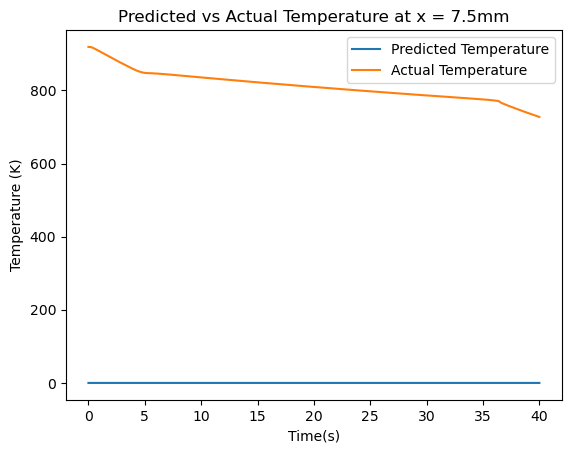

In [44]:
model = model.cpu()
inputs = inputs.cpu()
temp_inp = temp_inp.cpu()
temp_nn = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model

temp_nn = temp_nn.reshape(num_steps+1, num_points) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, time_end, num_steps+1)
plt.figure
plt.plot(time_ss, temp_nn[:,num_points//2], label='Predicted Temperature')
plt.plot(time_ss, temperature_history[:,num_points//2], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()


In [45]:
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

print(train_losses.shape, test_losses.shape)

(2000,) (2000,)


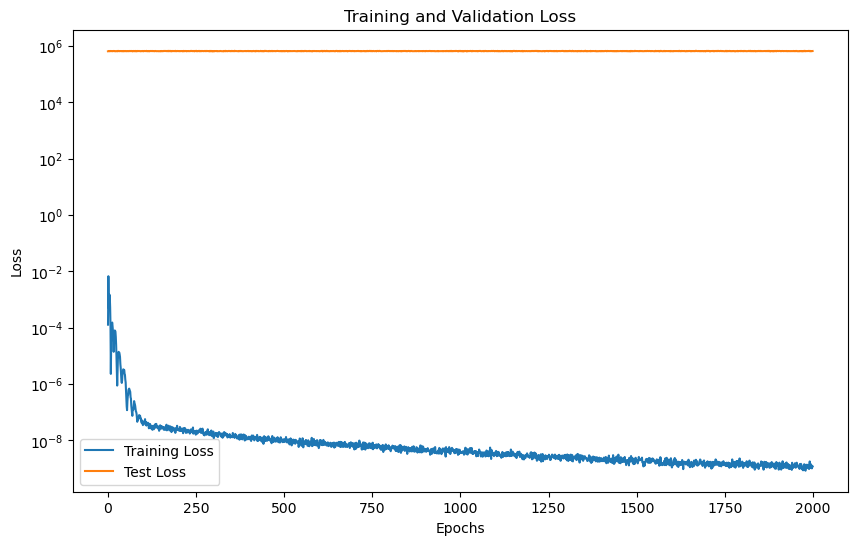

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [47]:
# plt.figure(figsize=(10, 6))
# plt.plot(pd_losses, label='Pde Loss')
# plt.plot(initc_losses, label='Initial Loss')
# plt.plot(bc_losses, label='BC Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

